# About

Theoretical plots of the analysis pertaining to the N-dimensional Kuramoto system with adaptive delays. Does not require any exported numerical simulations from MATLAB scripts.

Uses the following packages and functions:

funlib:
 - Omega2D
 - eig2D_cubic
 - eig2D_det

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Generate arrays to plot

## Parameters

In [2]:
g = 1.5
omega0 = w0 = 1.0
gain = 30
tau0 = 0.1

# Parameter dictionary
param = {'g': g,
         'omega0': omega0,
         'gain': gain,
         'tau0': tau0
         }

# Settings
steps = 500

## Synchronization states

In [3]:
# Fixed-point functions
Omega_fun = lambda Omega, delta2: funlib.Omega_infty(Omega, delta2, param, L=2*pi, steps=steps) - Omega

# Generate error meshes of Omega_fun
part_Omega = 200
part_delta = 200

cap = 0.5

# Processing function
z_fun = lambda x: x

# Generate error meshes
Omega_arr = np.linspace(w0 - g, w0 + g, num=part_Omega)
delta_arr = np.linspace(0,1, num=part_delta)
delta_mesh, Omega_mesh = np.meshgrid(delta_arr, Omega_arr)

err_mesh = np.zeros(Omega_mesh.shape)
for j in range(Omega_arr.size):
    for k in range(delta_arr.size):
        new_err = Omega_fun(Omega_mesh[j,k], delta_mesh[j,k]**2)
        err_mesh[j,k] = np.max((np.min((new_err, cap)), -cap))
    
z_mesh = z_fun(err_mesh)
# z_mesh = z_mesh / np.abs(z_mesh).max()

# Set the limits of the plot to the limits of the data
Omega_min = Omega_mesh.min()
Omega_max = Omega_mesh.max()
delta_min = delta_mesh.min()
delta_max = delta_mesh.max()
z_bound = np.abs(z_mesh).max()

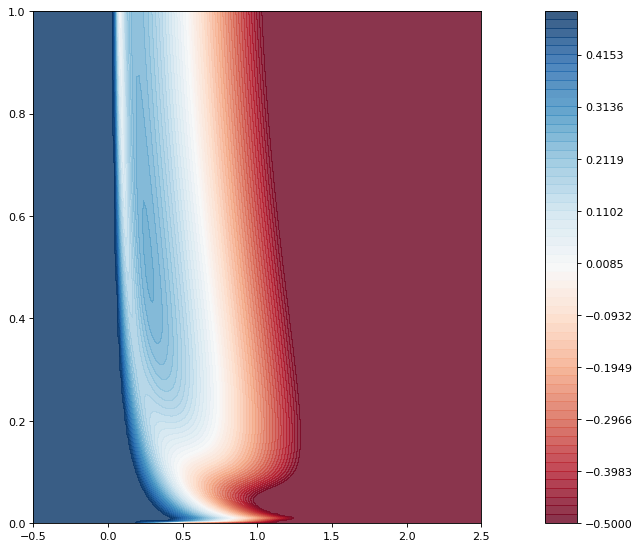

In [4]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.1, 0.1, 0.7, 0.8]  # Fig 2a: Synchronization states (roots of R_gain)
bbox1 = [0.9, 0.1, 0.05, 0.8] 

alpha = 0.8
levels = np.linspace(-z_bound, z_bound, 60)

fig, ax = plt.subplots(2, figsize=(8, 8), dpi=80)

ax[0].set_position(bbox0)
ax[1].set_position(bbox1)

c = ax[0].contourf(Omega_mesh, delta_mesh, z_mesh, levels, cmap='RdBu', alpha=alpha)
ax[0].axis([Omega_min, Omega_max, delta_min, delta_max])

# Colourbar
fig.colorbar(c, cax=ax[1]) 

## Eigenvalues

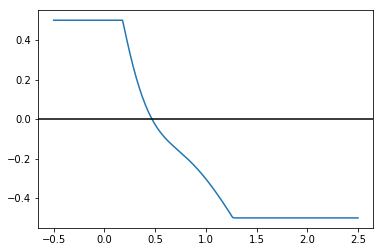

In [5]:
# Horizontal slice
delta0 = 0.1

# Find index
ind = np.argmin(np.abs(delta_arr - delta0))

fig, ax = plt.subplots(1,1)

ax.plot(Omega_arr, z_mesh[:,ind])
ax.axhline(y=0, color='black')

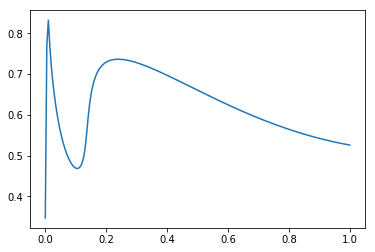

In [6]:
# Obtain Omega = Omega(delta) function
Omega_roots = np.zeros(delta_arr.size+1)
Omega_roots[0] = w0

for k in range(delta_arr.size):
    deltak = delta_arr[k]
    Omega_funk = lambda Omega: Omega_fun(Omega, deltak**2)
    new_root = rootlib.find_root(Omega_funk, Omega_roots[k], w0-g, w0+g, steps=100)
    if new_root[1]:
        Omega_roots[k+1] = new_root[0]
        
Omega_roots = Omega_roots[1:]

fig, ax = plt.subplots(1,1)

ax.plot(delta_arr, Omega_roots)

## Eigenvalues

In [7]:
# Choose a point:
Omega_root = 0.66
ind = np.argmin(np.abs(Omega_roots - Omega_root))
Omega = Omega_roots[ind]
delta2 = delta_arr[ind]**2

# Numerical options
steps = 200
L = pi
M = 5

# Expansion
I_0 = eigenlib.cos_fold_gain(Omega, delta2, tau0, gain, L=L, steps=steps)
coeffs = eigenlib.eig_coeffs(M, Omega, delta2, tau0, gain)
coeffs[0] = I_0

eig_int = lambda z: gain*g*(np.sum(coeffs*eigenlib.powers(z,M))*np.exp(-z*tau0/gain) - I_0)
eig_err = lambda z: eig_int(z) - z

eig_int2 = lambda z: gain*g*eigenlib.cos_int(z, Omega, delta2, tau0, gain, L=pi, steps=steps)
eig_err2 = lambda z: eig_int(z) - z

# Polynomial roots
coeffs2 = coeffs.copy()
coeffs2[0] += gain*g*I_0
coeffs2[1] += 1
poly_roots = np.roots(np.flip(coeffs2,0))

### Eigenvalue plot for 1st synchronization state

In [12]:
eig_err2(-1)

5650.9752335713765

In [9]:
# Ranges
range_u1 = 1
range_v1 = 5

part_u1 = 300
part_v1 = 300

cap1 = 100

# Processing function
z_fun1 = lambda x: x

# Generate error meshes

u_arr1 = np.linspace(-range_u1, range_u1, num=part_u1)
v_arr1 = np.linspace(-range_v1, range_v1, num=part_v1)
v_mesh1, u_mesh1 = np.meshgrid(v_arr1, u_arr1)

err_mesh1 = np.zeros(u_mesh1.shape)

for k in range(u_arr1.size):
    for l in range(v_arr1.size):
        err_mesh1[k,l] = np.min((np.abs(eig_err2(u_mesh1[k,l] + 1j*v_mesh1[k,l])), 1))

# Transform err_mesh
z_mesh1 = err_mesh1
# z_mesh1 = z_mesh1 / np.abs(z_mesh1).max()

# Set the limits of the plot to the limits of the data
u_min1 = u_mesh1.min()
u_max1 = u_mesh1.max()
v_min1 = v_mesh1.min()
v_max1 = v_mesh1.max()

array([[ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       [ 0.5,  0.5,  0.5, ...,  0.5,  0.5,  0.5],
       ...,
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.5, ..., -0.5, -0.5, -0.5]])

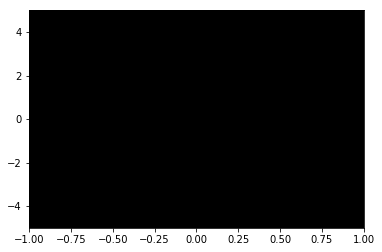

In [10]:
fig, ax = plt.subplots(1,1)

# Figure 2c
c = ax.pcolormesh(u_mesh1, v_mesh1, z_mesh1, cmap='binary', vmin=0, vmax=1) # cmap='RdBu'
ax.axis([u_min1, u_max1, v_min1, v_max1])
    
# ax.axhline(y=0) # x-axis
# ax.axvline(x=0) # y-axis

err_mesh

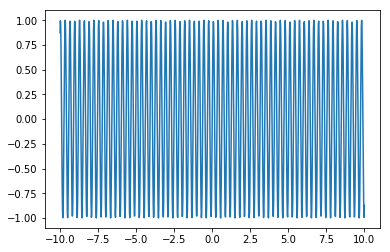

In [13]:
fig, ax = plt.subplots(1,1)

A = 20
x_arr = np.linspace(-10, 10, num=1000)
y_arr = np.sin(A*x_arr)
y_arr2 = 1 - y_arr**2/2 

ax.plot(x_arr, y_arr)